# Exercise 5: Naive Bayes Classifier

In [180]:
# Naive Bayes Classifier
import numpy as np
import pandas as pd
import os
import re


def to_tokens(text):
    '''
    Extract alphabetic tokens from a text, convert them to lowercase, and return the counts of tokens in a Series.
    '''
    # Extract the tokens
    tokens = re.findall('[a-z]+', text.lower())
    # Count the tokens
    return pd.Series(tokens).value_counts()


class TextClassifier:
    '''
    Multinomial Naive Bayes for text classification.
    '''

    def __init__(self, smoothing=0):
        '''
        Initialize the classifier.
        '''
        self.smoothing = smoothing

    def fit(self, train_data):
        '''
        Train the classifier on the given training data.
        '''
        # Compute the prior probabilities
        self.label_probs = train_data['label'].value_counts() / len(train_data)
        # Initialize the counts for each token
        self.token_counts = {
            label: pd.Series(dtype='int')
            for label in self.label_probs.index
        }
        documents = train_data.groupby('label')['sample'].sum()
        self.token_counts = documents.apply(to_tokens).T.fillna(0)
        # Compute the conditional probabilities for each token
        self.token_probs = (self.token_counts + self.smoothing) / (
            self.token_counts.sum() + self.smoothing * len(self.token_counts))

        return self

    def predict(self, text):
        '''
        Classify the given text using the trained classifier.
        '''
        # Compute the log of joint probabilities
        log_probs = np.log(self.label_probs)
        for label in self.label_probs.index:
            for token, count in to_tokens(text).items():
                if token in self.token_probs[label]:
                    log_probs[label] += count * np.log(
                        self.token_probs[label][token])

        # Return the label with the highest posterior probability
        return log_probs.idxmax()


def load_data(dir):
    '''
    Load the data from the given directory.
    '''
    data = []
    for filename in os.listdir(dir):
        with open(dir + filename, 'r') as f:
            sample = f.read()
        label = 'spam' if 'spmsg' in filename else 'notspam'
        data.append((label, sample))
    return pd.DataFrame(data, columns=['label', 'sample'])


def evaluate(label, pred, p, n):
    '''
    Evaluate the performance of a binary classifier.
    '''
    # Compute the confusion matrix
    TP = np.sum((label == p) & (pred == p))
    FP = np.sum((label == n) & (pred == p))
    TN = np.sum((label == n) & (pred == n))
    FN = np.sum((label == p) & (pred == n))
    confusion_matrix = pd.DataFrame([[TP, FP], [FN, TN]],
                                    index=[p, n],
                                    columns=[p, n])

    # Compute the accuracy, precision, recall, and F1 score
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * TP / (2 * TP + FP + FN)

    # Print the results
    print(f'Confusion matrix:\n{confusion_matrix}\n')
    print(f'Accuracy:  {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall:    {recall:.2f}')
    print(f'F1 score:  {f1_score:.2f}')
    print()

    # Return all the results in a Dataframe
    return pd.DataFrame(
        [[TP, FP, TN, FN, accuracy, precision, recall, f1_score]],
        index=['result'],
        columns=[
            'TP', 'FP', 'TN', 'FN', 'accuracy', 'precision', 'recall',
            'f1_score'
        ])


def main(smoothing):
    # Load the training and test data
    train_data = load_data('hw5_nb/train-mails/')
    test_data = load_data('hw5_nb/test-mails/')
    # Train the classifier
    clf = TextClassifier(smoothing).fit(train_data)
    # Test and evaluate the classifier
    test_data['prediction'] = test_data['sample'].apply(clf.predict)
    return evaluate(test_data['label'], test_data['prediction'], 'spam',
                    'notspam')


# CASE1: Using the Laplace smoothing technique
print('CASE1: Using the Laplace smoothing technique\n')
res1 = main(smoothing=1)
# CASE2: Without using the Laplace smoothing techniqu
print('CASE2: Without using the Laplace smoothing technique\n')
res2 = main(smoothing=0)

# Save the DataFrame
df = pd.concat([res1, res2])
df.index = ['Laplace smoothing', 'No smoothing']
df.to_csv('naive_bayes.csv')
df

CASE1: Using the Laplace smoothing technique

Confusion matrix:
         spam  notspam
spam       47        0
notspam     2      242

Accuracy:  0.99
Precision: 1.00
Recall:    0.96
F1 score:  0.98

CASE2: Without using the Laplace smoothing technique

Confusion matrix:
         spam  notspam
spam        8        0
notspam    41      242

Accuracy:  0.86
Precision: 1.00
Recall:    0.16
F1 score:  0.28



,TP,FP,TN,FN,accuracy,precision,recall,f1_score
Laplace smoothing,47,0,242,2,0.993127,1.0,0.959184,0.979167
No smoothing,8,0,242,41,0.859107,1.0,0.163265,0.280702


In [ ]:
# Do the same thing with sklearn
from sklearn.naive_bayes import MultinomialNB


def main(smoothing):
    clf = MultinomialNB(alpha=smoothing)
    # Load the training data and preprocess
    train_data = load_data('hw5_nb/train-mails/')
    train_samples = train_data['sample'].apply(to_tokens).fillna(0)
    # Train the classifier
    clf.fit(train_samples, train_data['label'])
    # Load the test data and preprocess
    test_data = load_data('hw5_nb/test-mails/')
    # Test and evaluate the classifier
    test_data['prediction'] = clf.predict(
        pd.DataFrame(test_data['sample'].apply(to_tokens),
                     columns=train_samples.columns).fillna(0))
    evaluate(test_data['label'], test_data['prediction'], 'spam', 'notspam')


# CASE1: Using the Laplace smoothing technique
main(smoothing=1)
# CASE2: Without using the Laplace smoothing technique
main(smoothing=0)

# Exercise 8: Logistic Regression

In [2]:
# Logistic Regression

import os
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.family'] = 'serif'

# Load MNITS dataset from hw5_lr.mat
import scipy.io as sio
mat = sio.loadmat('hw5_lr.mat')
train_data, test_data = mat['train_data'], mat['test_data']
train_label, test_label = mat['train_label'], mat['test_label']

# Normalize pixel values
train_data = (train_data / 255).reshape(-1, 28 * 28)
test_data = (test_data / 255).reshape(-1, 28 * 28)

# Convert label for binary classification (digit 6 or not)
train_label = (train_label == 6).astype(int).flatten()
test_label = (test_label == 6).astype(int).flatten()

In [ ]:
plt.imshow(train_data[0].reshape(28, 28), cmap='gray')

In [3]:
def undersample(X, y, random_state=0):
    '''
    Undersample the majority class.
    '''
    # Find the minority and majority classes
    label, count = np.unique(y, return_counts=True)
    if count[0] < count[1]:
        minority = label[0]
        majority = label[1]
    else:
        minority = label[1]
        majority = label[0]
    # Undersample the majority class
    idx = np.random.RandomState(random_state).choice(
        np.where(y == majority)[0], count[1], replace=False)
    return np.vstack((X[y == minority], X[idx])), np.hstack(
        (y[y == minority], y[idx]))


# Undersample the training data
train_data_rus, train_label_rus = undersample(train_data, train_label)

In [ ]:
np.unique(train_label_rus, return_counts=True)

In [4]:
def evaluate_binary_classifier(label, pred):
    '''
    Evaluate the performance of a binary classifier.
    '''
    # Compute the confusion matrix
    TP = np.sum((label == 1) & (pred == 1))
    FP = np.sum((label == 0) & (pred == 1))
    TN = np.sum((label == 0) & (pred == 0))
    FN = np.sum((label == 1) & (pred == 0))
    confusion_matrix = pd.DataFrame([[TP, FP], [FN, TN]],
                                    index=[1, 0],
                                    columns=[1, 0])

    # Compute the accuracy, precision, recall, and F1 score
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * TP / (2 * TP + FP + FN)

    # Print the results
    print(f'Confusion matrix:\n{confusion_matrix}\n')
    print(f'Accuracy:  {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall:    {recall:.2f}')
    print(f'F1 score:  {f1_score:.2f}')
    print()

    # Return all the results in a Dataframe
    return pd.DataFrame(
        [[TP, FP, TN, FN, accuracy, precision, recall, f1_score]],
        index=['result'],
        columns=[
            'TP', 'FP', 'TN', 'FN', 'Accuracy', 'Precision', 'Recall',
            'F1 score'
        ])

In [ ]:
# Using sklearn
import warnings
import sklearn.exceptions
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler

warnings.filterwarnings('ignore',
                        category=sklearn.exceptions.ConvergenceWarning)

# CASE1: Imbalanced dataset
clf = LogisticRegression()
clf.fit(train_data, train_label)
pred = clf.predict(test_data)
evaluate_binary_classifier(test_label, pred)

# CASE2: Undersampling
rus = RandomUnderSampler(random_state=0)
train_data_rus, train_label_rus = rus.fit_resample(train_data, train_label)
clf.fit(train_data_rus, train_label_rus)
pred = clf.predict(test_data)
evaluate_binary_classifier(test_label, pred)


In [19]:
def sigmoid(x):
    '''
    Sigmoid function.
    '''
    if x >= 0:
        z = np.exp(-x)
        return 1 / (1 + z)
    else:
        z = np.exp(x)
        return z / (1 + z)


def log(x):
    '''
    Log function.
    '''
    if x == 0:
        return -1e10
    else:
        return np.log(x)


sigmoid = np.vectorize(sigmoid)
log = np.vectorize(log)


class BinaryClassifier:
    '''
    Binomial Logistic Regression using GD, SGD, or mini-batch SGD with L2 regularization.
    '''

    def __init__(self,
                 alpha=0.01,
                 learning_rate=None,
                 batch_size=None,
                 target_accuracy=0.90,
                 max_iter=5000,
                 random_state=0):
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.target_accuracy = target_accuracy
        self.max_iter = max_iter
        self.random_state = random_state

        self.n = None  # Number of samples
        self.d = None  # Number of features
        self.X = None  # Feature matrix with bias
        self.y = None  # Label vector
        self.w = None  # Weight vector
        self.L = None  # Lipschitz constant
        self.prob = None  # Predicted probabilities
        self.grad = None  # Gradient of loss
        self.loss_list = []  # Cross-entropy loss
        self.score_list = []  # Accuracy score
        self.total_iter = 0  # Total number of iterations
        self.total_time = 0  # Total time elapsed
        self.converged = False  # Whether the algorithm converged

    def fit(self,
            X,
            y,
            w0=None,
            verbose=False,
            record_loss=False,
            record_score=True):
        '''
        Train the classifier.
        '''
        # Set the random seed
        np.random.seed(self.random_state)
        # Initialize the parameters
        self.n = X.shape[0]
        self.d = X.shape[1]
        self.X = np.hstack((np.ones((self.n, 1)), X))
        self.y = y
        self.w = w0.copy()
        if self.w is None:
            self.w = np.random.randn(self.d + 1)
        if self.learning_rate is None:
            # Estimate the Lipschitz constant (See Problem 1)
            self.L = (self.d + 1) / 4
        else:
            self.L = 1 / self.learning_rate
        self.score_list.clear()
        self.loss_list.clear()
        self.total_time = 0
        self.converged = False
        # Minimize the loss function
        for self.total_iter in range(1, self.max_iter + 1):
            # Start timer
            start = time.time()
            # Compute the gradient of the loss function
            if self.batch_size is None:
                # Full gradient
                self.prob = sigmoid(self.X @ self.w)
                self.grad = self.X.T @ (self.prob - self.y) / self.n
            else:
                # Stochastic gradient
                idx = np.random.randint(self.X.shape[0], size=self.batch_size)
                self.prob = sigmoid(self.X[idx] @ self.w)
                self.grad = self.X[idx].T @ (self.prob -
                                             self.y[idx]) / self.batch_size
            # Update the weights
            self.w -= 1 / (self.L + self.alpha) * (self.grad +
                                                   self.alpha * self.w)
            # Stop timer
            duration = time.time() - start
            self.total_time += duration
            # As we need to evaluate the accuracy score in each iteration, we must compute the full probability vector here, which cause the stochastic gradient descent to be as slow as the full gradient descent.
            if self.batch_size is not None:
                self.prob = sigmoid(self.X @ self.w)
            # Compute the cross-entropy loss
            loss = self.loss()
            if record_loss:
                self.loss_list.append(self.loss())
            # Compute the accuracy score
            score = self.score()
            if record_score:
                self.score_list.append(score)
            # Print the progress
            if verbose:
                print(f'Iteration {self.total_iter:4d}: '
                      f'Loss = {loss:.4f}, '
                      f'Score = {score:.4f}, '
                      f'Time = {duration:.4f} sec')
            # Stop if the target accuracy is reached
            if self.target_accuracy < score:
                self.converged = True
                break

    def predict(self, X):
        '''
        Predict the labels.
        '''
        prob = self.predict_proba(X)
        return (prob > 0.5).astype(int)

    def predict_proba(self, X):
        '''
        Predict the probabilities of the positive class.
        '''
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return sigmoid(X @ self.w)

    def loss(self):
        '''
        Evaluate the cross-entropy loss on the training set.
        '''
        return -np.mean(self.y * log(self.prob) +
                        (1 - self.y) * log(1 - self.prob)
                        ) + self.alpha / 2 * np.sum(self.w**2)

    def score(self):
        '''
        Evaluate the accuracy on the training set.
        '''
        return np.mean((self.prob >= 0.5).astype(int) == self.y)

    def plot_loss(self, ax=None, **kwargs):
        '''
        Plot the loss function.
        '''
        if ax is None:
            ax = plt.gca()
        ax.plot(self.loss_list, **kwargs)

    def plot_score(self, ax=None, **kwargs):
        '''
        Plot the accuracy score.
        '''
        if ax is None:
            ax = plt.gca()
        ax.plot(self.score_list, **kwargs)

    def plot(self, ax=None, **kwargs):
        if ax is None:
            _, ax = plt.subplots(1, 2, figsize=(12, 4))
        self.plot_loss(ax[0], **kwargs)
        self.plot_score(ax[1], **kwargs)

    def report(self, data, label):
        '''
        Test the classifier on the given dataset.
        '''
        pred = self.predict(data)
        df = evaluate_binary_classifier(label, pred)
        df['Time'] = self.total_time
        df['Iter'] = self.total_iter
        df['Converged'] = self.converged
        return df


n = train_data.shape[0]
d = train_data.shape[1]
X = np.hstack((np.ones((n, 1)), train_data))
# Compute a Lipschitz constant
L = 0.25 * np.linalg.norm(X, ord=2)**2 / n
# Generate random initial weights
np.random.seed(0)
w0 = np.random.randn(d + 1)

clf = BinaryClassifier(learning_rate=1 / L, random_state=0)


Imbalanced dataset & Full gradient

lambda = 0
----------------
Iteration    1: Loss = 1.7463, Score = 0.8831, Time = 0.1618 sec
Iteration    2: Loss = 1.7085, Score = 0.8816, Time = 0.1724 sec
Iteration    3: Loss = 1.6718, Score = 0.8802, Time = 0.1366 sec
Iteration    4: Loss = 1.6361, Score = 0.8780, Time = 0.1421 sec
Iteration    5: Loss = 1.6015, Score = 0.8762, Time = 0.1310 sec
Iteration    6: Loss = 1.5679, Score = 0.8739, Time = 0.1365 sec
Iteration    7: Loss = 1.5355, Score = 0.8718, Time = 0.1264 sec
Iteration    8: Loss = 1.5041, Score = 0.8697, Time = 0.1461 sec
Iteration    9: Loss = 1.4738, Score = 0.8678, Time = 0.1418 sec
Iteration   10: Loss = 1.4445, Score = 0.8657, Time = 0.1623 sec
Iteration   11: Loss = 1.4164, Score = 0.8636, Time = 0.1315 sec
Iteration   12: Loss = 1.3893, Score = 0.8619, Time = 0.2351 sec
Iteration   13: Loss = 1.3631, Score = 0.8595, Time = 0.1423 sec
Iteration   14: Loss = 1.3380, Score = 0.8578, Time = 0.1419 sec
Iteration   15: Loss = 1.

/var/folders/m1/q37_rsrs61965xlsdgq5hcm00000gn/T/ipykernel_8624/1121658975.py:19: RuntimeWarning: invalid value encountered in long_scalars
  precision = TP / (TP + FP)


Iteration    1: Loss = 1.7463, Score = 0.8831, Time = 0.0002 sec
Iteration    2: Loss = 1.7463, Score = 0.8832, Time = 0.0001 sec
Iteration    3: Loss = 1.7464, Score = 0.8832, Time = 0.0004 sec
Iteration    4: Loss = 1.7464, Score = 0.8832, Time = 0.0003 sec
Iteration    5: Loss = 1.7464, Score = 0.8832, Time = 0.0004 sec
Iteration    6: Loss = 1.7465, Score = 0.8832, Time = 0.0004 sec
Iteration    7: Loss = 1.7465, Score = 0.8832, Time = 0.0004 sec
Iteration    8: Loss = 1.7465, Score = 0.8832, Time = 0.0004 sec
Iteration    9: Loss = 1.7498, Score = 0.8835, Time = 0.0003 sec
Iteration   10: Loss = 1.7920, Score = 0.8866, Time = 0.0003 sec
Iteration   11: Loss = 1.3404, Score = 0.8507, Time = 0.0001 sec
Iteration   12: Loss = 1.5309, Score = 0.8852, Time = 0.0005 sec
Iteration   13: Loss = 1.5403, Score = 0.8858, Time = 0.0002 sec
Iteration   14: Loss = 1.5403, Score = 0.8858, Time = 0.0003 sec
Iteration   15: Loss = 1.5403, Score = 0.8858, Time = 0.0004 sec
Iteration   16: Loss = 1.

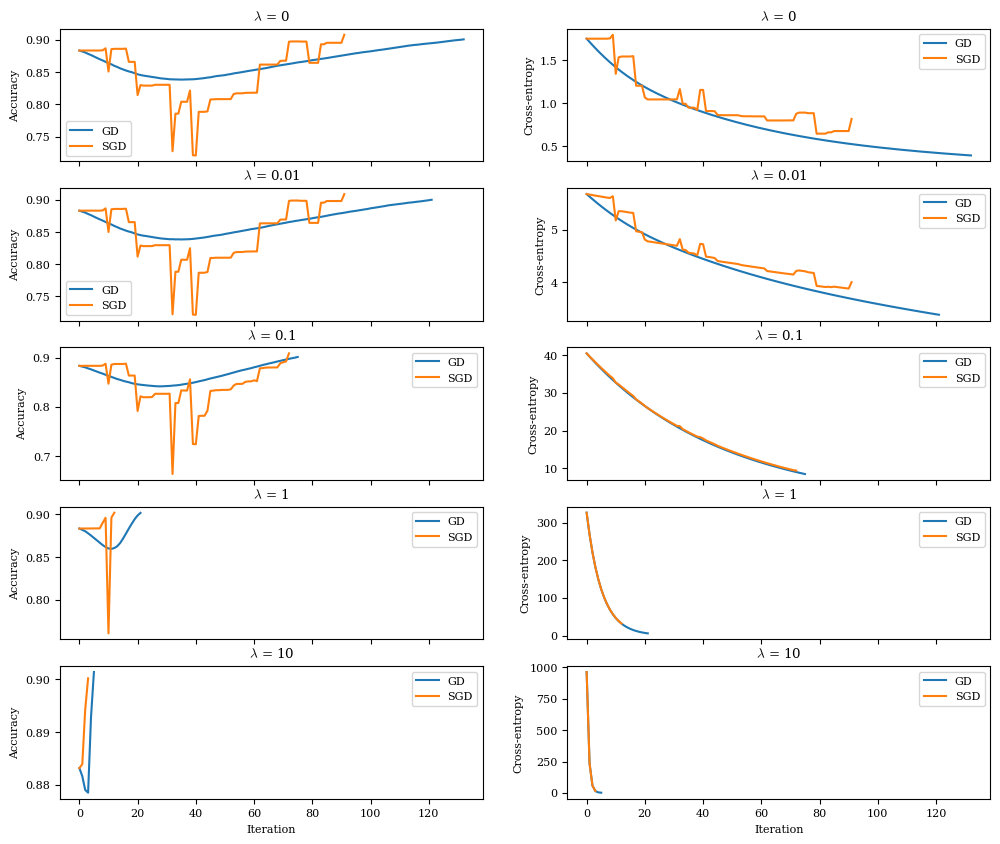

In [15]:
lamb_list = [0, 0.01, 0.1, 1, 10]

fig, ax = plt.subplots(len(lamb_list),
                       2,
                       figsize=(12, 2 * len(lamb_list)),
                       sharex=True)
for i in range(len(lamb_list)):
    ax[i, 0].set_title(f'$\lambda$ = {lamb_list[i]}')
    ax[i, 1].set_title(f'$\lambda$ = {lamb_list[i]}')
    ax[i, 0].set_ylabel('Accuracy')
    ax[i, 1].set_ylabel('Cross-entropy')
ax[len(lamb_list) - 1, 0].set_xlabel('Iteration')
ax[len(lamb_list) - 1, 1].set_xlabel('Iteration')

res1 = []
# CASE1: Imbalanced dataset & Full gradient
print('\nImbalanced dataset & Full gradient\n')
for i, lamb in enumerate(lamb_list):
    print(f'lambda = {lamb}')
    print('----------------')
    clf.alpha = lamb
    clf.batch_size = None
    clf.fit(train_data, train_label, w0=w0, verbose=True, record_loss=True)
    res1.append(clf.report(test_data, test_label))
    clf.plot_score(ax[i, 0], label='GD')
    clf.plot_loss(ax[i, 1], label='GD')
res1 = pd.concat(res1)

res2 = []
# CASE2: Imbalanced dataset & Stochastic gradient
print('\nImbalanced dataset & Stochastic gradient\n')
for i, lamb in enumerate(lamb_list):
    print(f'lambda = {lamb}')
    print('----------------')
    clf.alpha = lamb
    clf.batch_size = 1
    clf.fit(train_data, train_label, w0=w0, verbose=True, record_loss=True)
    res2.append(clf.report(test_data, test_label))
    clf.plot_score(ax[i, 0], label='SGD')
    clf.plot_loss(ax[i, 1], label='SGD')
    ax[i, 0].legend()
    ax[i, 1].legend()
res2 = pd.concat(res2)

fig.savefig('imbalanced.pdf')

In [28]:
res1.index = lamb_list
res2.index = lamb_list
res = pd.concat([res1, res2], keys=['GD', 'SGD'])
res.to_csv('imbalanced.csv')


Undersampled dataset & Full gradient

lambda = 0
----------------
Iteration    1: Loss = 8.6201, Score = 0.4939, Time = 0.0320 sec
Iteration    2: Loss = 7.3987, Score = 0.4908, Time = 0.0251 sec
Iteration    3: Loss = 6.2392, Score = 0.4910, Time = 0.0548 sec
Iteration    4: Loss = 5.1790, Score = 0.4948, Time = 0.0550 sec
Iteration    5: Loss = 4.2606, Score = 0.5052, Time = 0.0378 sec
Iteration    6: Loss = 3.5138, Score = 0.5204, Time = 0.0323 sec
Iteration    7: Loss = 2.9438, Score = 0.5384, Time = 0.0349 sec
Iteration    8: Loss = 2.5295, Score = 0.5526, Time = 0.0497 sec
Iteration    9: Loss = 2.2370, Score = 0.5697, Time = 0.0358 sec
Iteration   10: Loss = 2.0332, Score = 0.5847, Time = 0.0460 sec
Iteration   11: Loss = 1.8897, Score = 0.5979, Time = 0.0481 sec
Iteration   12: Loss = 1.7847, Score = 0.6081, Time = 0.0450 sec
Iteration   13: Loss = 1.7034, Score = 0.6204, Time = 0.0505 sec
Iteration   14: Loss = 1.6368, Score = 0.6331, Time = 0.0349 sec
Iteration   15: Loss = 

/var/folders/m1/q37_rsrs61965xlsdgq5hcm00000gn/T/ipykernel_8624/1121658975.py:19: RuntimeWarning: invalid value encountered in long_scalars
  precision = TP / (TP + FP)


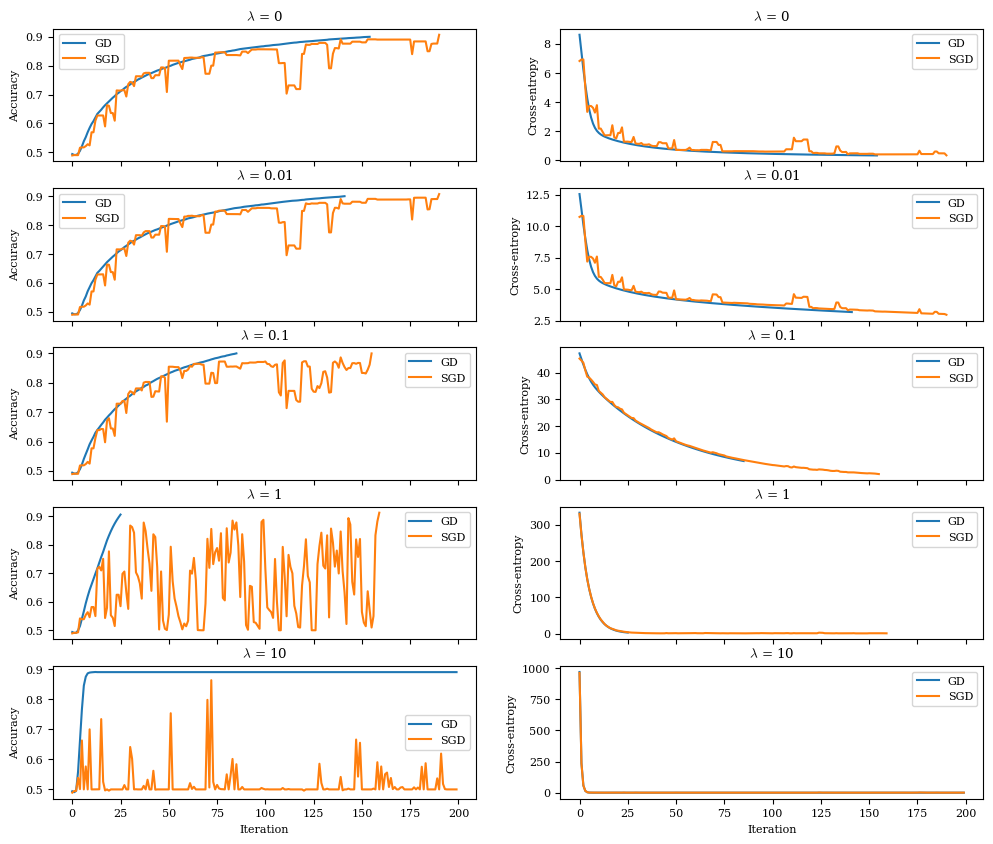

In [21]:
fig, ax = plt.subplots(len(lamb_list),
                       2,
                       figsize=(12, 2 * len(lamb_list)),
                       sharex=True)
for i in range(len(lamb_list)):
    ax[i, 0].set_title(f'$\lambda$ = {lamb_list[i]}')
    ax[i, 1].set_title(f'$\lambda$ = {lamb_list[i]}')
    ax[i, 0].set_ylabel('Accuracy')
    ax[i, 1].set_ylabel('Cross-entropy')
ax[len(lamb_list) - 1, 0].set_xlabel('Iteration')
ax[len(lamb_list) - 1, 1].set_xlabel('Iteration')

clf.max_iter = 200

res3 = []
# CASE3: Undersampled dataset & Full gradient
print('\nUndersampled dataset & Full gradient\n')
for i, lamb in enumerate(lamb_list):
    print(f'lambda = {lamb}')
    print('----------------')
    clf.alpha = lamb
    clf.batch_size = None
    clf.fit(train_data_rus, train_label_rus, w0=w0, verbose=True, record_loss=True)
    res3.append(clf.report(test_data, test_label))
    clf.plot_score(ax[i, 0], label='GD')
    clf.plot_loss(ax[i, 1], label='GD')
res3 = pd.concat(res3)

res4 = []
# CASE4: Undersampled dataset & Stochastic gradient
print('\nUndersampled dataset & Stochastic gradient\n')
for i, lamb in enumerate(lamb_list):
    print(f'lambda = {lamb}')
    print('----------------')
    clf.alpha = lamb
    clf.batch_size = 1
    clf.fit(train_data_rus, train_label_rus, w0=w0, verbose=True, record_loss=True)
    res4.append(clf.report(test_data, test_label))
    clf.plot_score(ax[i, 0], label='SGD')
    clf.plot_loss(ax[i, 1], label='SGD')
    ax[i, 0].legend()
    ax[i, 1].legend()
res4 = pd.concat(res4)

fig.savefig('undersampled.pdf')

In [30]:
res3.index = lamb_list
res4.index = lamb_list
res = pd.concat([res3, res4], keys=['GD', 'SGD'])
res.to_csv('undersampled.csv')